In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
gstock_data = pd.read_csv('GOOG.csv')
gstock_data.columns = gstock_data.columns.str.lower()
gstock_data = gstock_data[['date', 'open', 'close']]

gstock_data['date'] = pd.to_datetime(gstock_data['date'].apply(lambda x: x.split(' ')[0]))
gstock_data.set_index('date', inplace=True)

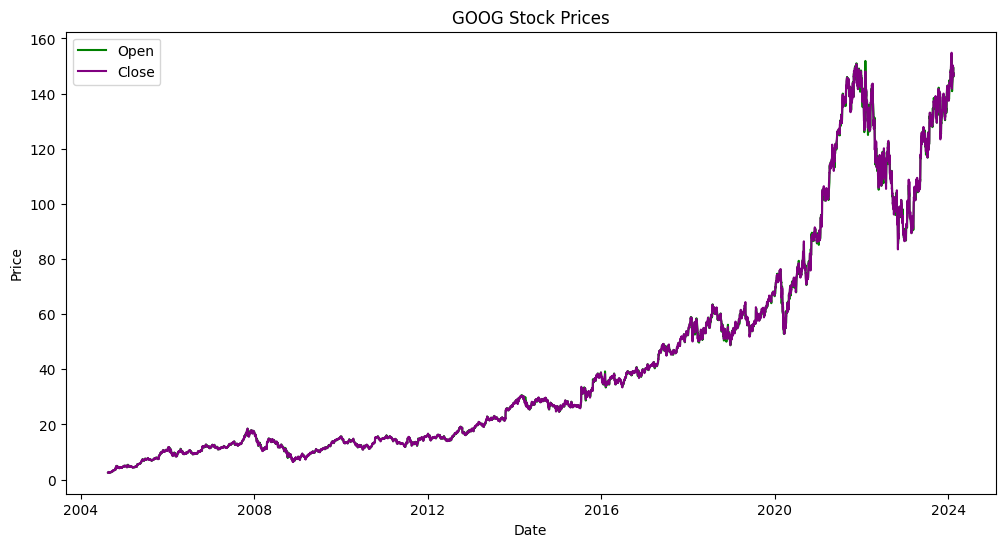

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gstock_data['open'], label='Open', color='green')
plt.plot(gstock_data['close'], label='Close', color='purple')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GOOG Stock Prices')
plt.legend()
plt.show()


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gstock_data)

In [ ]:
def create_sequences(data, window_size):
    if len(data) <= window_size:
        return [], []  # Termination condition
    train_data, test_data = data[:int(len(data) * 0.8)], data[int(len(data) * 0.8):]
    train_seq, train_label = create_sequences(train_data, window_size)
    return train_seq, train_label

window_size = 50
train_data, test_data = scaled_data[:int(len(scaled_data) * 0.8)], scaled_data[int(len(scaled_data) * 0.8):]
train_seq, train_label = create_sequences(train_data, window_size)
test_seq, test_label = create_sequences(test_data, window_size)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 50)            10600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30851 (120.51 KB)
Trainable params: 30851 (120.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_seq, train_label, epochs=50, batch_size=64, validation_data=(test_seq, test_label), verbose=1)


Epoch 1/50
61/61 [==============================] - 10s 87ms/step - loss: 0.0029 - mae: 0.0318 - val_loss: 0.0021 - val_mae: 0.0384
Epoch 2/50
61/61 [==============================] - 4s 62ms/step - loss: 4.1889e-04 - mae: 0.0132 - val_loss: 0.0031 - val_mae: 0.0475
Epoch 3/50
61/61 [==============================] - 5s 75ms/step - loss: 3.4803e-04 - mae: 0.0121 - val_loss: 0.0030 - val_mae: 0.0456
Epoch 4/50
61/61 [==============================] - 4s 65ms/step - loss: 3.5353e-04 - mae: 0.0120 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 5/50
61/61 [==============================] - 4s 61ms/step - loss: 3.1486e-04 - mae: 0.0114 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 6/50
61/61 [==============================] - 4s 69ms/step - loss: 2.8712e-04 - mae: 0.0109 - val_loss: 0.0015 - val_mae: 0.0317
Epoch 7/50
61/61 [==============================] - 4s 72ms/step - loss: 3.0984e-04 - mae: 0.0113 - val_loss: 0.0028 - val_mae: 0.0441
Epoch 8/50
61/61 [==============================] - 5s 80m

30/30 [==============================] - 1s 26ms/step
Shape of predicted_prices: (932, 1)
Shape of test_data: (982, 2)


In [ ]:
predicted_prices = model.predict(test_seq)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 2))
test_prices = scaler.inverse_transform(test_label.reshape(-1, 2))


30/30 [==============================] - 0s 14ms/step


In [ ]:
print("Predicted closing prices:\n", predicted_prices[28])
print("Actual closing prices:\n", test_prices[28])

Predicted closing prices:
 [76.50521 77.52348]
Actual closing prices:
 [74.515503 76.028999]


In [ ]:
test_prices = test_prices[-predicted_prices.shape[0]:]

# Calculate evaluation metrics
mse = mean_squared_error(test_prices, predicted_prices)
mae = mean_absolute_error(test_prices, predicted_prices)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 847.6843126814858
Mean Absolute Error (MAE): 25.103391708459416


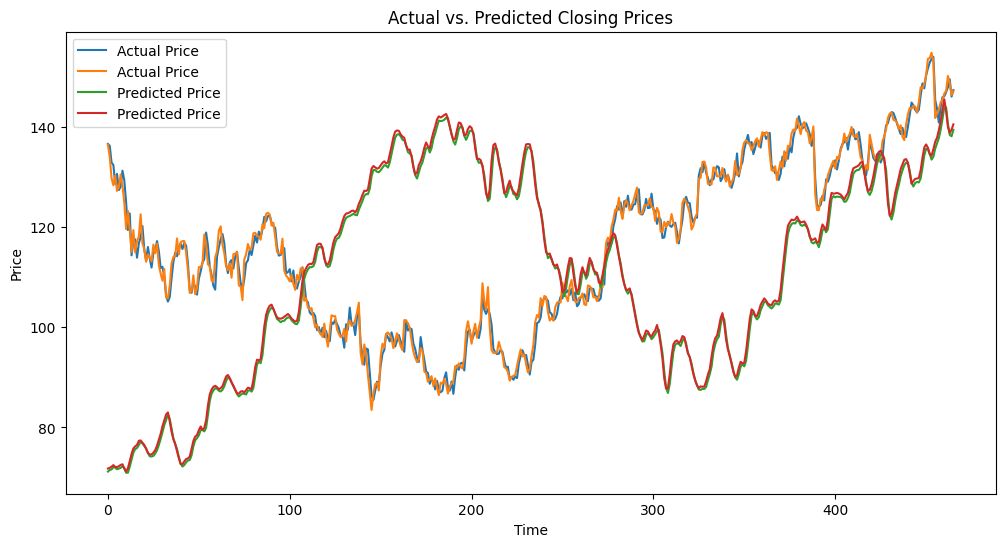

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Closing Prices')
plt.legend()
plt.show()


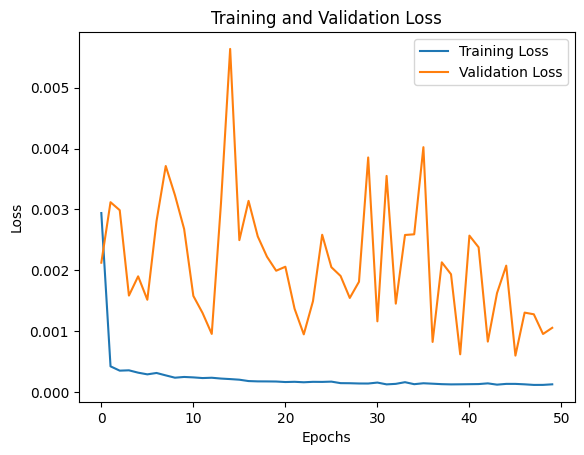

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()